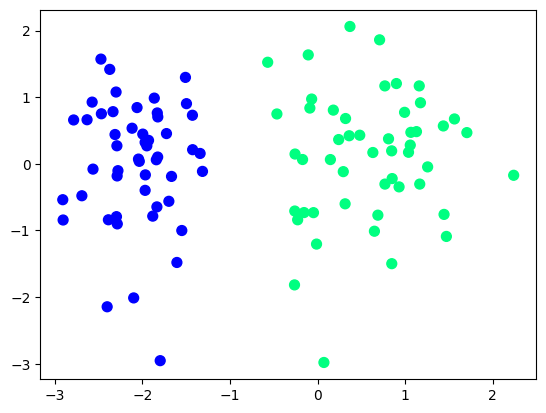

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_classes=2, n_features=2, n_clusters_per_class=1, class_sep=13,
                              n_informative=1, n_redundant=0, hypercube=False, random_state=41)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter', s=50)

In [56]:
class Neuron:
    def __init__(self, input_size, random_state=42, activation="relu"):
        np.random.seed(random_state)
        
        if isinstance(input_size, int):
            self.weights = np.random.randn(input_size)
            
        else:
            self.weights = np.random.randn(*input_size)
        
        self.bias = np.random.random(1)
        self.activation = activation
        
        self.input = None
        self.z = None
        self.output = None
        
    def __call__(self, x):
        return self.forward(x)
    
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))
    
    def relu (self, x):
        return x * (x > 0)
    
    def relu_derivative (self, x):
        return x>0
    
    
    def forward(self, input):
        self.input = input
        self.z = np.dot(input, self.weights) + self.bias
        if self.activation=='sigmoid':
            self.output = self.sigmoid(self.z)
        else:
            self.output  = self.relu(self.z)
        return self.output
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)
    
    def get_params(self):
        return self.weights, self.bias
    
    def backward(self, error, learning_rate=0.01):
        
        d_loss_ouptut = error
        if self.activation=="sigmoid":
            d_output_z = self.sigmoid_derivative(self.z)
        
        else:
            d_output_z = self.relu_derivative(self.z)
        
        d_z_w = self.input
        d_z_b = 1
        
        d_loss_w = d_loss_ouptut * d_output_z * d_z_w
        d_loss_b = d_loss_ouptut * d_output_z * d_z_b
        
        self.weights -= learning_rate * d_loss_w
        self.bias -= learning_rate * d_loss_b
        
        return error * d_output_z

In [57]:
class Layer:
    def __init__(self, input_size: int, n_neurons: int, activation: str='relu', learning_rate: float=0.01):
        self.n_neurons = n_neurons
        self.layer = [Neuron(input_size=input_size, activation=activation, random_state=i) for i in range(n_neurons)]
        self.learning_rate = learning_rate
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred)**2)
    
    def __call__(self, x):
        return np.array([n(x) for n in self.layer])
    
    def backward(self, error):
        next_error = np.zeros(self.layer[0].weights.shape[0])
        for i, neuron in enumerate(self.layer):
            neuron.backward(error[i], learning_rate=self.learning_rate)
            next_error += neuron.weights * error[i]
        return next_error
            
    def get_params(self):
        return [n.get_params() for n in self.layer]

In [58]:
epochs = 1000
num_features = 2

model = [
    Layer(2, 3),
    Layer(3, 1, activation='sigmoid')
]

In [60]:
losses = []

for epoch in range(epochs):
    total_loss = 0
    
    for features, target in zip(X, y):
        # Forward pass
        activations = [features]
        for layer in model:
            activations.append(layer(activations[-1].ravel()))
            
        yhat = activations[-1]
            
         # Calculate loss
        loss = model[-1].mse(target, yhat)
        total_loss += loss
            
        # Backward pass
        error = yhat - target
        for i in reversed(range(len(model))):
            error = model[i].backward(error)
                
    avg_loss = total_loss/len(y)
    losses.append(avg_loss)
    if epoch % 200==0:  
        print(f"EPOCH: {epoch} || LOSS: {avg_loss}")
        print('-'*100)

EPOCH: 0 || LOSS: 0.25756618791578345
----------------------------------------------------------------------------------------------------
EPOCH: 200 || LOSS: 0.003892039723951099
----------------------------------------------------------------------------------------------------
EPOCH: 400 || LOSS: 0.0017063567093217693
----------------------------------------------------------------------------------------------------
EPOCH: 600 || LOSS: 0.0010720508651497725
----------------------------------------------------------------------------------------------------
EPOCH: 800 || LOSS: 0.0007756698728020546
----------------------------------------------------------------------------------------------------


In [61]:
for layer in model:
    print(layer.get_params())

[(array([3.16826616, 0.36589269]), array([4.20740245])), (array([ 1.78578101, -0.89719898]), array([0.55918797])), (array([1.42274472, 0.06808896]), array([1.8986308]))]
[(array([2.0097778 , 0.46936904, 1.0557133 ]), array([-3.33211408]))]


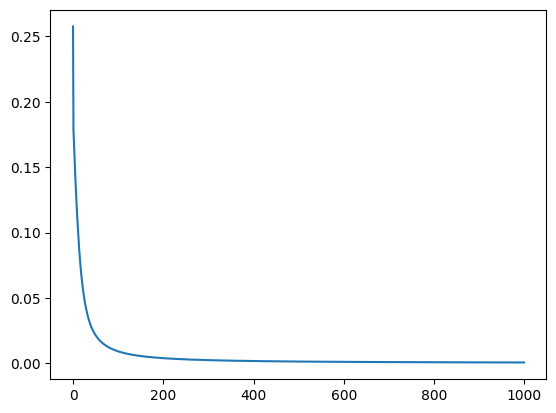

In [62]:
plt.plot(losses)